In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path

from matplotlib.patheffects import withStroke
from matplotlib.pyplot import text

from src.tools.plotter import store_sns, init_plots
from src.trace_set.database import Database
from src.trace_set.pollution import PollutionType

init_plots()

In [3]:
SCA_PALETTE = sns.light_palette(sns.color_palette()[2], n_colors=5)
DLLA_PALETTE = sns.light_palette(sns.color_palette()[0], n_colors=5)

titles = {
    Database.ascad: {
        PollutionType.gauss: "ASCAD (Masked, Gaussian noise)\nPerformance on 300.000 traces"
    },
    Database.ascad_none: {
        PollutionType.gauss: "ASCAD (Unprotected, Gaussian noise)\nPerformance on 30.000 traces",
        PollutionType.jitter: "ASCAD (Unprotected, Clock jitter)",
        PollutionType.delay: "ASCAD (Unprotected, Random delay)"
    },
    Database.aisy: {
        PollutionType.gauss: "AISy LA traces (Unprotected, Gaussian noise)\nPerformance on 2.500 traces",
        PollutionType.jitter: "AISy LA traces (Unprotected, Clock jitter)\nPerformance on 2.500 traces",
        PollutionType.delay: "AISy LA traces (Unprotected, Random delay)\nPerformance on 2.500 traces"
    }
}

xlabels = {
    PollutionType.gauss: "Gaussian noise parameter",
    PollutionType.jitter: "Clock jitter parameter",
    PollutionType.delay: "Random delay parameter"
}

methods = {
    "sca_hw": ("Profiled SCA ($\overline{kr}$)", SCA_PALETTE[3], "-"),
    "dlla9": ("DL-LA 9 class ($p$)", DLLA_PALETTE[3], "-"),
    "dlla2": ("Wegener DL-LA ($p$)", DLLA_PALETTE[2], "--"),
}

<AxesSubplot:title={'center':'ASCAD (Masked, Gaussian noise)\nPerformance on 300.000 traces'}, xlabel='param', ylabel='$p$-value'>

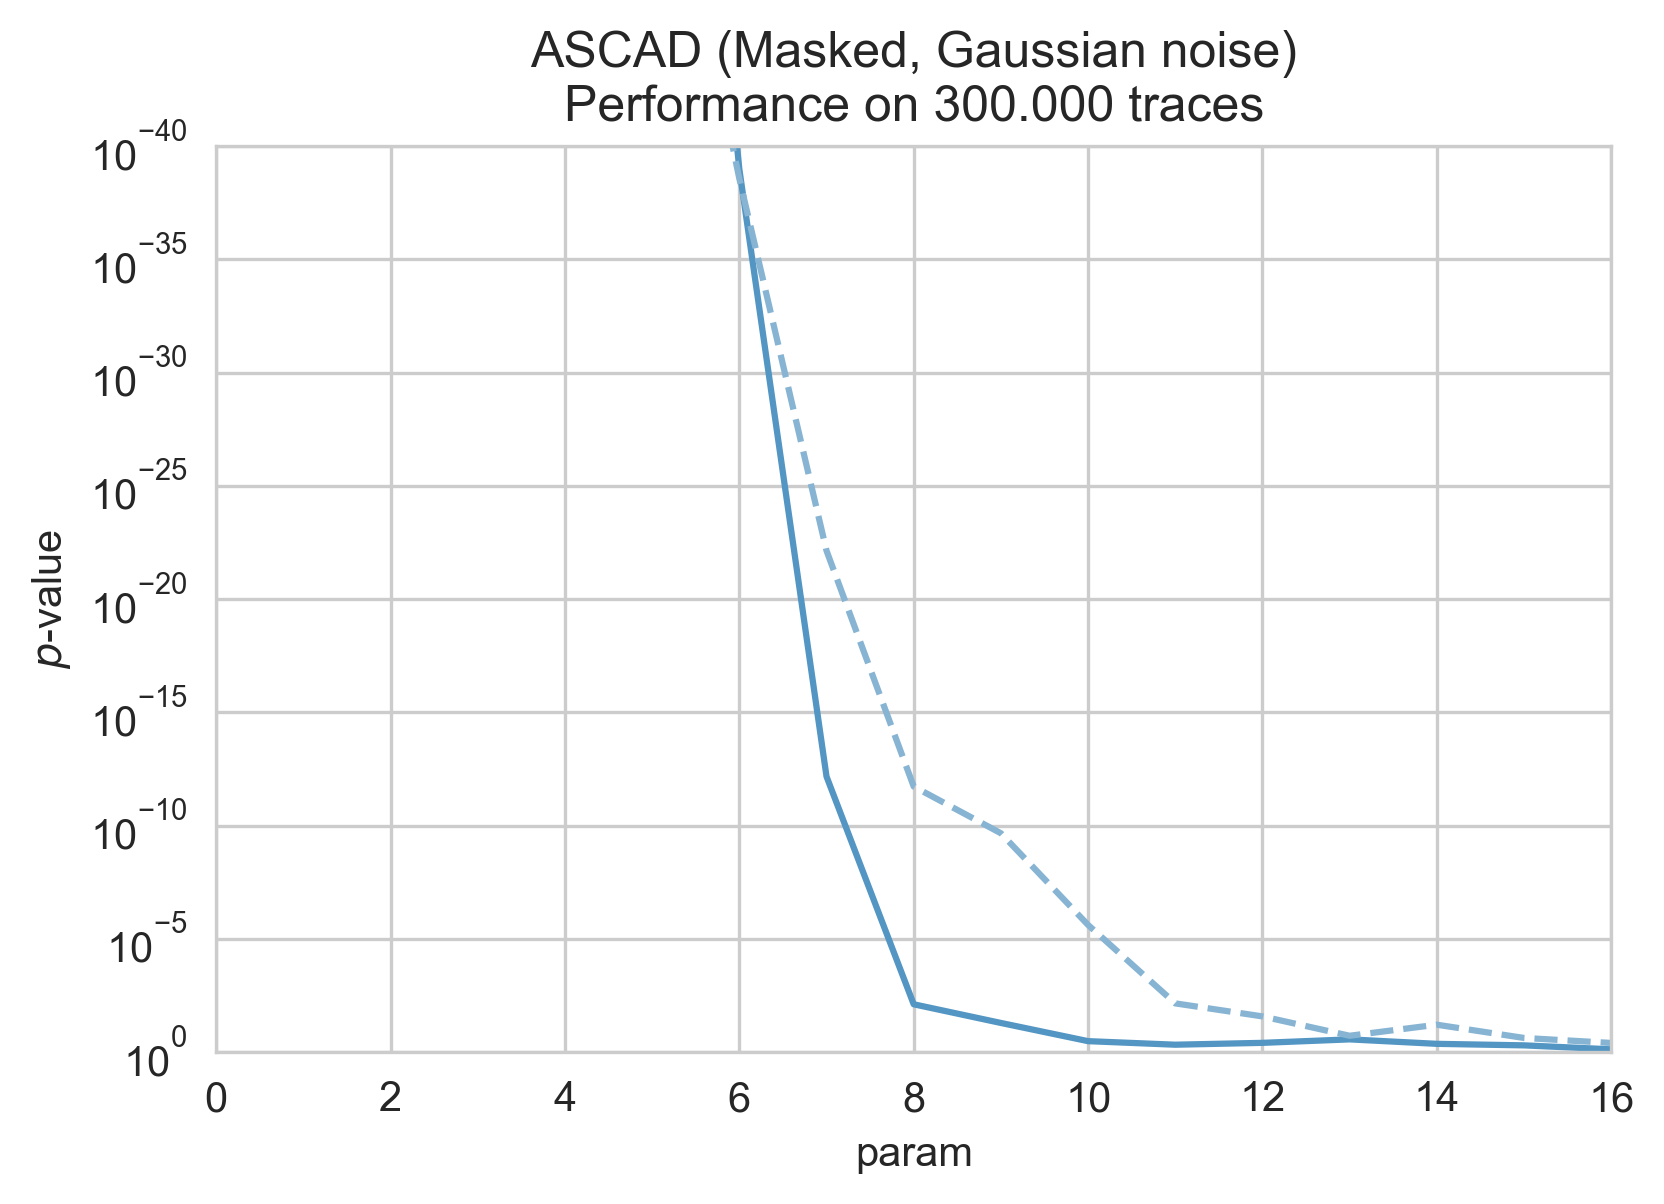

In [89]:
def fetch_results(db: Database, pollution: PollutionType, num_traces: str, dir_name = ""):
    suffix = ""
    if num_traces is not None:
        suffix = f"_{num_traces}"
    file_name = path.join(dir_name, f"results_{db.name}{suffix}.csv")

    df = pd.read_csv(file_name, sep=";")
    df = df[df.pollution == pollution.name].drop(columns=[df.pollution.name])

    gdf = df.groupby(df.method)

    return gdf, df

def plot_p_value(db: Database, pollution: PollutionType, num_traces: str = None, xlim=(0, 16)):
    gdf, df = fetch_results(db, pollution, num_traces, "../pollution")

    g = None
    for method, (label, color, style) in methods.items():
        if method in gdf.groups:
            method_group = gdf.get_group(method)
            med = method_group.groupby(df.param).median()
            g = sns.lineplot(x=med.param, y=med.p, label=label, color=color, linestyle=style)

    g.set(yscale="log",
          ylabel="$p$-value",
          title=titles[db][pollution], xlim=xlim,
           ylim=(10 ** -(5 * 8), 1))
    # g.grid(False)
    g.invert_yaxis()
    g.get_legend().remove()

    return g

plot_p_value(Database.ascad, PollutionType.gauss)

In [5]:
THRESHOLD_COLOR = "#FF000080"

def moving_average(a, n=3) :
    ret = np.cumsum(np.array(a))
    ret[n:] = ret[n:] - ret[:-n]

    add = int(np.floor(n / 2))

    return np.concatenate(([ret[0]] * add, ret[n - 1:] / n)), n - add

moving_average(np.arange(0, 10))

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), 2)

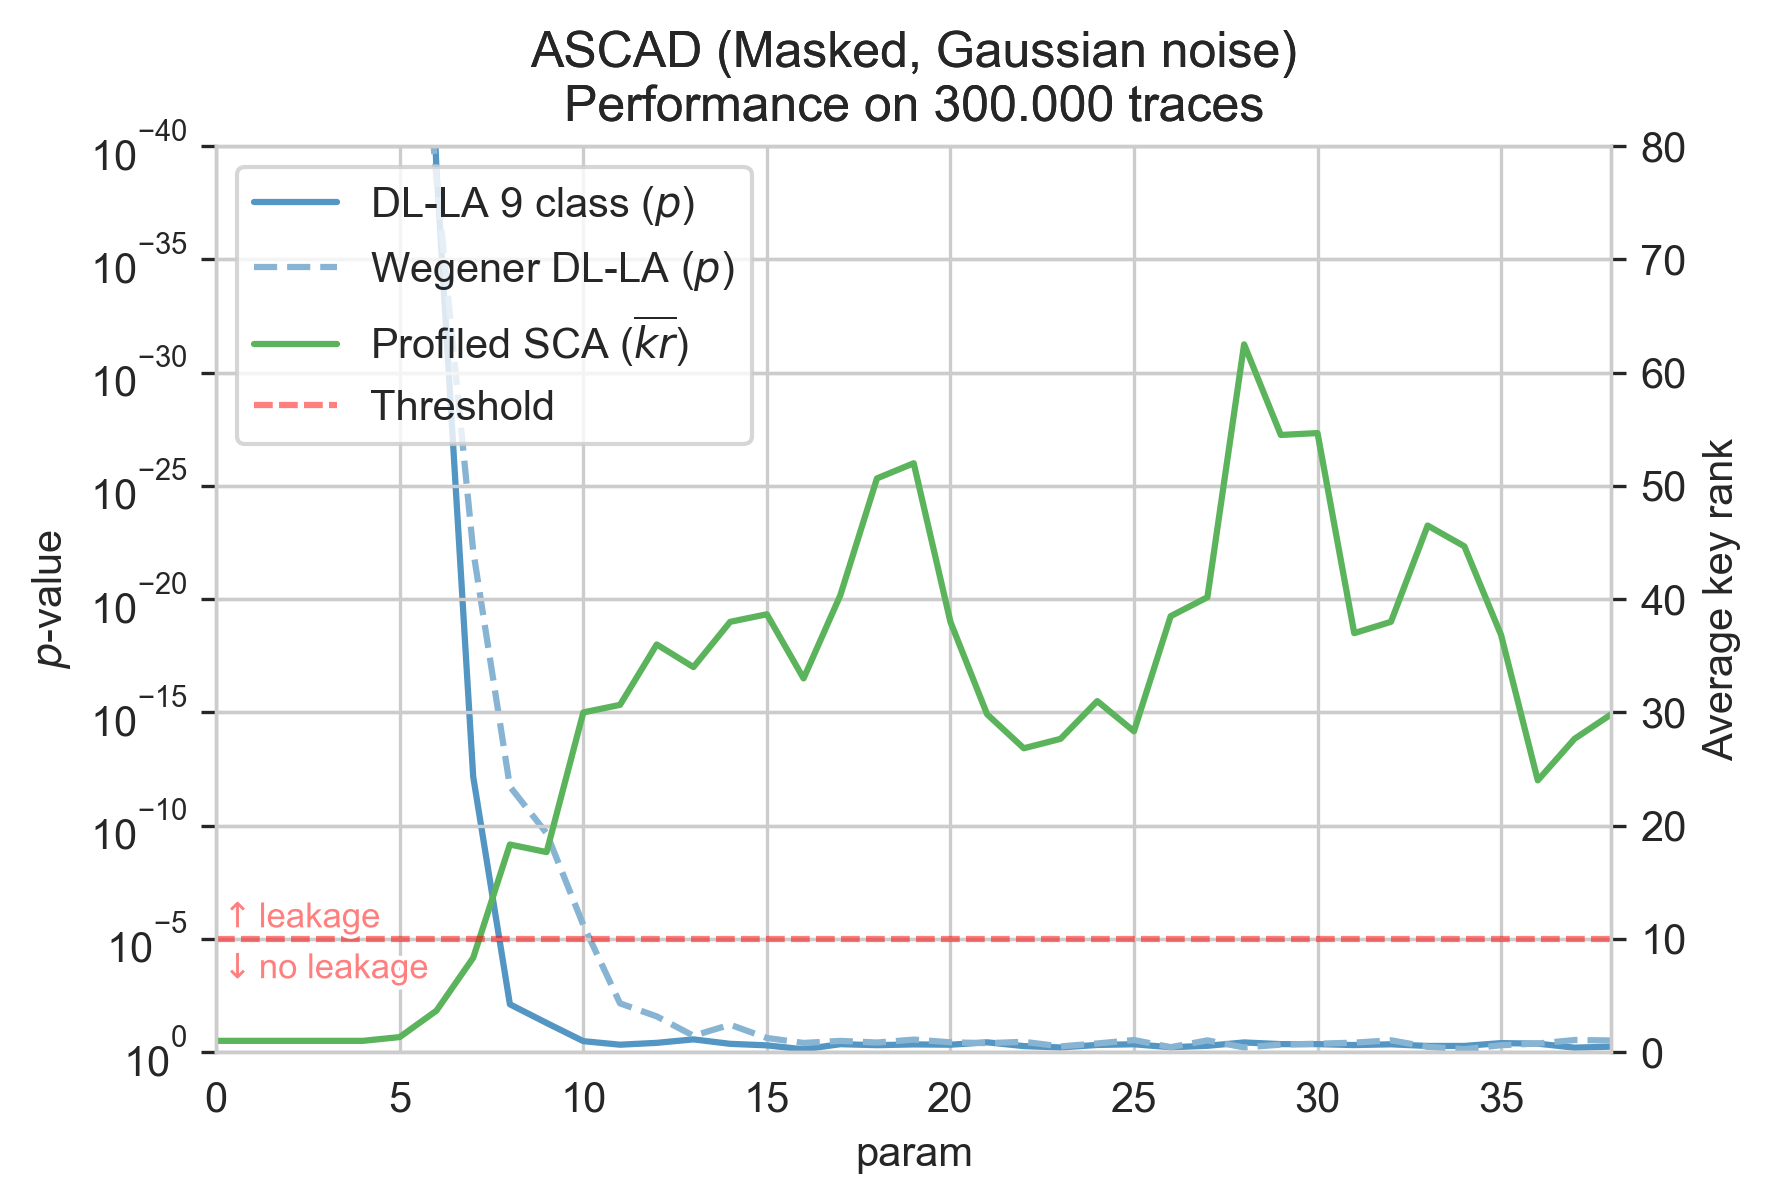

In [96]:
def plot_kr(db: Database, pollution: PollutionType, num_traces: str = None):
    gdf, df = fetch_results(db, pollution, num_traces)

    g = None
    for method, (label, color, style) in methods.items():
        if method in gdf.groups:
            method_group = gdf.get_group(method)
            med = method_group.groupby(df.param).median()

            g = sns.lineplot(x=med.param[:-1], y=moving_average(med.kr)[0], label=label, color=color, linestyle=style)

    g.set(ylim=(0,80), xlabel=xlabels[pollution], ylabel="Average key rank",
          title=titles[db][pollution])

    return g

KR_THRESH = 10

def plot(db: Database, pollution: PollutionType, xlim=(0, 16), num_traces: str = None):
    g = plot_p_value(db, pollution, num_traces, xlim)
    g2 = plt.twinx()
    plot_kr(db, pollution, num_traces)

    len_axis = 40
    t_line = [KR_THRESH] * len_axis
    sns.lineplot(data={"Threshold": t_line}, palette=[THRESHOLD_COLOR], dashes=[(3,1)])

    stroke = [withStroke(linewidth=2, foreground='w')]

    text(0, KR_THRESH + 1, '$\\uparrow$leakage', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)
    text(0, KR_THRESH - 1, '$\\downarrow$no leakage', va='top', color=THRESHOLD_COLOR, size="small").set_path_effects(stroke)

    handles1, labels1 = g.get_legend_handles_labels()
    handles2, labels2 = g2.get_legend_handles_labels()
    g2.legend(handles1+handles2, labels1+labels2, loc="upper left")

    store_sns(g, f"pollution-results-{db.name}-{pollution.name}")

plot(Database.ascad, PollutionType.gauss, xlim=(0, 38))